## Importing the dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/70-dog-breedsimage-data-set")

print("Path to dataset files:", path)

100%|██████████| 215M/215M [00:10<00:00, 21.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2


In [2]:
import os
os.listdir(path)

['train', 'dogs.csv', 'test', 'valid']

In [3]:
train_path = path + '/train'
test_path = path + '/test'
valid_path = path + '/valid'
# os.listdir(train_path)

In [4]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

In [5]:
train_imgs = image_dataset_from_directory(train_path, image_size=(224, 224), batch_size=32,labels='inferred', label_mode='int')
train_imgs

test_imgs = image_dataset_from_directory(test_path, image_size=(224, 224), batch_size=32,labels='inferred', label_mode='int')
test_imgs

valid_imgs = image_dataset_from_directory(valid_path, image_size=(224, 224), batch_size=32,labels='inferred', label_mode='int')
valid_imgs

Found 7946 files belonging to 70 classes.
Found 700 files belonging to 70 classes.
Found 700 files belonging to 70 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Adding Data Augmentation to avoid overfitting

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


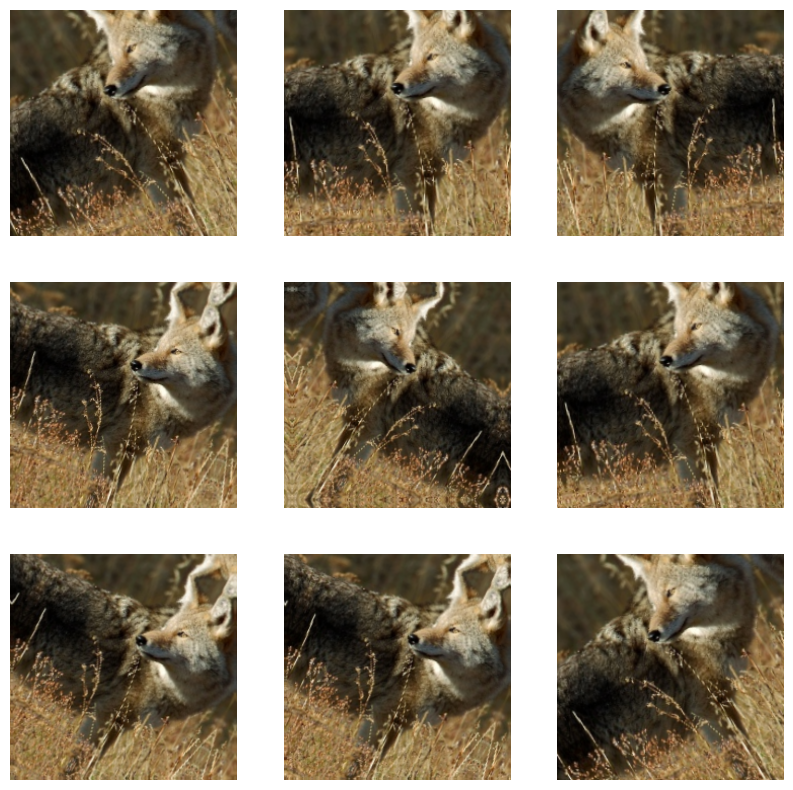

In [6]:
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(224, 224, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

plt.figure(figsize=(10, 10))
for images, _ in train_imgs.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Building the CNN

In [36]:
from tensorflow import keras
from tensorflow.keras import layers, models

# Create the CNN model
model = models.Sequential([
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(1024, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(2048, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(2048, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(70, activation='softmax')  # 70 classes in the dog breed dataset
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy','sparse_categorical_accuracy'])

## Adding Early Stopping

In [37]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=7, restore_best_weights=True,mode='auto')

## Fitting the Model

In [38]:
training = model.fit(
    train_imgs,
    epochs=50,
    validation_data=valid_imgs,
    callbacks=[early_stopping]
)

Epoch 1/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.0219 - loss: 5.7866 - sparse_categorical_accuracy: 0.0219 - val_accuracy: 0.0314 - val_loss: 4.0233 - val_sparse_categorical_accuracy: 0.0314
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.0578 - loss: 3.8926 - sparse_categorical_accuracy: 0.0578 - val_accuracy: 0.0857 - val_loss: 3.6593 - val_sparse_categorical_accuracy: 0.0857
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.1021 - loss: 3.6284 - sparse_categorical_accuracy: 0.1021 - val_accuracy: 0.1329 - val_loss: 3.3585 - val_sparse_categorical_accuracy: 0.1329
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.1326 - loss: 3.4512 - sparse_categorical_accuracy: 0.1326 - val_accuracy: 0.1414 - val_loss: 3.3045 - val_sparse_categorical_accuracy: 0.1414
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.1550 - loss: 3.2951 - sparse_categorical_accuracy: 0.1550 - val_accuracy: 0.1829 - val_loss:

## Evaluating the Model

In [39]:
loss, accuracy, val_sprse_categorical = model.evaluate(test_imgs)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4086 - loss: 2.3922 - sparse_categorical_accuracy: 0.4086


In [47]:
from tensorflow.keras.models import load_model
model = load_model('cnn.h5')

In [48]:
loss, accuracy, val_sprse_categorical = model.evaluate(test_imgs)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5152 - loss: 2.0502 - sparse_categorical_accuracy: 0.5152


## Validation & Accuracy Graph

<Axes: title={'center': 'Accuracy'}>

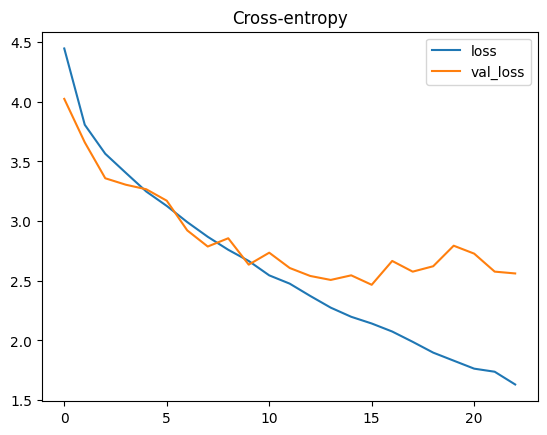

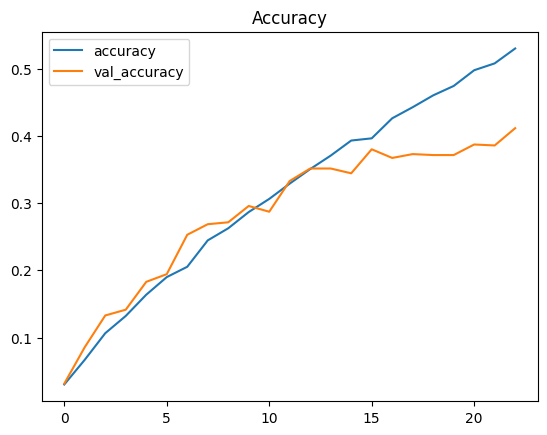

In [40]:
import pandas as pd

history_df = pd.DataFrame(training.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

## Making Test Predicitons

In [49]:
import numpy as np

predictions = model.predict(test_imgs)
predictions

predictedVal1 = np.argmax(predictions, axis=1)
print(predictedVal1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
[56 47 13  1 32 63 36 55 64 67 65 17 63 17  8  5 17 63 25 31 52 49 39 11
 11 34 50  1 66 64 20 48 43 54 26 43 13 20 59 29 43 44 34 50 39 47 43 32
 32 10 34 62 48 31 39 69 46 18 38 17 54 32 67 54 21 46 68 31 43 47 37  9
 38 20 49  1 32 66 58 11 15 65 18  1 61 65 58 55 18 63 40  6 15 52 42  7
 35 46 51 17 66 39 56 58 22 24 46  5 43 39 25 30 20 30  7 63 40 44 64 12
  6 44  3 45 46 36 47 28 63 13  7 27 34 48  9 16  1 37 55 25 45 32 54  1
 19 66 17 63 39  7 47 63 63 23 15 55 34 22 57 48 12 29 34  9 51  5 38 55
 43 15 58 21  8 20  6  7  4 13 14  5 38 31 45 13 25 18  5 43 33 28 20 40
 49 66 44 63 14 51 66 42 26 20  0 58 28 63 32 49 49 35 61 60 15  2 65 48
  2  2 31 37 68  4 55 65 34 13 38 34 19  9 66  1 29 64 69  7 14 20  2 49
  5  9 17 12 21 56 33 11 60 61 45  9  0  6 44 30  2  3 41 54 38 48 58 63
 40 38 50 23 29 42  9 13 65 66 39 42 50 62 32  5 16 17 23  7 11 45 52  8
  2 45 10 53 62 59 56 39 39 40 23 38 48 43 49 59 12 16 55 29 14 11 27 53
 12 32 20 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


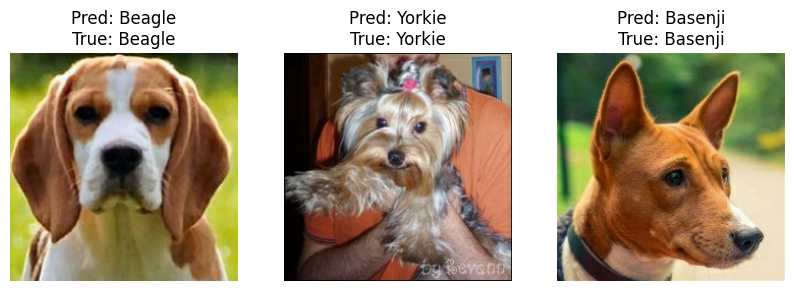

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Class names (if known)
class_names = test_imgs.class_names  # Only works if you used labels='inferred'

# Get one batch from the dataset
for images, labels in test_imgs.take(1):
    predictions = model.predict(images)

    predicted_classes = np.argmax(predictions, axis=1)

    # Plot images with predictions
    plt.figure(figsize=(10, 5))
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

        pred_label = class_names[predicted_classes[i]]
        true_label = class_names[labels[i].numpy()]
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
    break


All 3 dog prediction are right!

## Saving the model

In [14]:
model.save('cnn.h5')
